# Cowboy results for X

***Add notes about your experiment here.***

*NB* requires a kernel with pycorn. 

If you don't have one, you can use 'shifty'

To get shifty as a kernal option, log onto the digs and run:
/software/containers/scripts/registerapptainerkernel.sh /software/containers/shifty.sif

In [2]:
import glob
from datetime import date

today = date.today().strftime("%Y%m%d")[2:]
print(f"Today: {today}")
# import warnings; warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import sys, os

sys.path.append("/net/software/lab/cowboy")
from wetlab_utils_v9 import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

sns.set_theme(
    context="talk",
    palette="colorblind",
    style="ticks",
    rc={"axes.spines.right": False, "axes.spines.top": False},
)

Today: 241122


## Input Dataframe

`echo_df`: This is the `%run_name%_df.csv` files generated by johnbercow that contains your eblock sequences and other information.
- This script automatically renames lines to work, and assumes LM0627 as your vector
- If more complex cloning combinatorics is desired, include a `Vector` column in the spreadhseet to specify the entry vector for each eBlock. 

***If not using the Johnbercow function, `echo_df` should at a minimum contain the following columns:***
   - `Name`: the name of your design.
   - `Destination Well`: the destination well of the transfer.
   - `Destination Plate Name`: 96w expression plate identifier.
   - `eblock`: the eBlock sequence.
   - `Vector`: the GGA entry vector ID, e.g. `LM0627`. others can be found at /software/lab/johnbercow/entry_vectors/
   - `n_chains`: if your proteins are oligomers, this is the oligomeric state. not necessary if all your proteins are monomers

In [3]:
### CHANGE THESE
expression_name = "test_v9"
echo_df = pd.read_csv(
    "2024_07_25_e139_e_coli_BsaI_df.csv") # This path should be the path to the df file outputted by johnbercow
if "Vector" not in echo_df:
    echo_df["Vector"] = "LM0627" # LM0627, LM1371,etc
#echo_df["n_chains"] = 3 #If your things are oligomers and they are all the same oligomer you can put the oligomeric state in here
    
#This part makes the johnbercow csv work for this if you already have all the right lines it doesn't have any effect
if 'eblock' not in echo_df.columns:
    echo_df = echo_df.rename(columns={"Sequence": "eblock"})
if 'Destination Plate Name' not in echo_df.columns:
    echo_df = echo_df.rename(columns={"plate_id": "Destination Plate Name"})
if 'Destination Well' not in echo_df.columns:
    echo_df = echo_df.rename(columns={"Well Position": "Destination Well"})
echo_df.head()
echo_df

,design_name,eblock,length_eblock,readin_order,design_aa_seq,LM0627_cloned_plasmid_seq,ORF_from_LM0627,exp_aa_seq_from_LM0627,idt_score,order_name,is_frag,is_hto,design_id,position,Destination Plate Name,Destination Well,Name,Vector
0,plt_00037_93170_refined_1_clean_5_38,atactacggtctcaaggaGCGTTTAAAGAAGCGATTAGCCTGTTTA...,515,0,AFKEAISLFKSKVTTSDYNSWVQLAKKTDNPQAVLDAGNKHTSYLD...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggagcgtttaaagaagcgattagcctgtttaaaagcaaag...,MSGAFKEAISLFKSKVTTSDYNSWVQLAKKTDNPQAVLDAGNKHTS...,0,e139,False,False,lig0001,1_A1,1,A1,lig0001__A1__e139.1__plt_00037_93170_refined_1...,LM0627
1,plt_00038_112587_refined_1_clean_4_49,atactacggtctcaaggaAGCAGCGCGCGTGTGACCCTGCGCGCGT...,479,1,SSARVTLRAYSNDPEVVGELVQRMSCEELAGFLRAKAEAGERVAIV...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaagcagcgcgcgtgtgaccctgcgcgcgtattctaacg...,MSGSSARVTLRAYSNDPEVVGELVQRMSCEELAGFLRAKAEAGERV...,0,e139,False,False,lig0002,1_A2,1,B1,lig0002__A2__e139.1__plt_00038_112587_refined_...,LM0627
2,plt_00038_203810_refined_0_clean_6_46,atactacggtctcaaggaAAACGCCTGACCCTGCTGTTTACCCAGA...,464,2,KRLTLLFTQSDVPKEIIDKANEANIRVYITANPSDKNYENNHRKAK...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaaaacgcctgaccctgctgtttacccagagcgatgtgc...,MSGKRLTLLFTQSDVPKEIIDKANEANIRVYITANPSDKNYENNHR...,0,e139,False,False,lig0003,1_A3,1,A2,lig0003__A3__e139.1__plt_00038_203810_refined_...,LM0627
3,plt_00038_49234_refined_1_clean_1_6,atactacggtctcaaggaGTGGATATTGCGATTGGTGTTGCGGTGG...,392,3,VDIAIGVAVGNTPEELARNREKVLELAKEYNVELDELAEAPSCEAV...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggagtggatattgcgattggtgttgcggtgggcaacaccc...,MSGVDIAIGVAVGNTPEELARNREKVLELAKEYNVELDELAEAPSC...,0,e139,False,False,lig0004,1_A4,1,B2,lig0004__A4__e139.1__plt_00038_49234_refined_1...,LM0627
4,plt_00038_112287_refined_1_clean_5_97,atactacggtctcaaggaGTTGAAGAAATCGTGGAATCCGTGGTGC...,479,4,VEEIVESVVRLAAKLGAIILIPVNRADMFDPEWQALQQLIEEIAAR...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggagttgaagaaatcgtggaatccgtggtgcgtctggcgg...,MSGVEEIVESVVRLAAKLGAIILIPVNRADMFDPEWQALQQLIEEI...,0,e139,False,False,lig0005,1_A5,1,A3,lig0005__A5__e139.1__plt_00038_112287_refined_...,LM0627
5,plt_00038_5154_refined_1_clean_8_95,atactacggtctcaaggaAAGAAAATCATGCTGGTGCTGAACTTTG...,488,5,KKIMLVLNFDNDNPELVKAILAVVAKTGLLELIAVFANSEEAAKRL...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaaagaaaatcatgctggtgctgaactttgataacgata...,MSGKKIMLVLNFDNDNPELVKAILAVVAKTGLLELIAVFANSEEAA...,0,e139,False,False,lig0006,1_A6,1,B3,lig0006__A6__e139.1__plt_00038_5154_refined_1_...,LM0627
6,plt_00038_46883_refined_0_clean_8_81,atactacggtctcaaggaATGCGCCGCCTGTTTCTGGTGCAGGTGG...,530,6,MRRLFLVQVVGLNEDDPEAQLAEARKVAERAGIPFGGVVDTPEAAA...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaatgcgccgcctgtttctggtgcaggtggtgggcctga...,MSGMRRLFLVQVVGLNEDDPEAQLAEARKVAERAGIPFGGVVDTPE...,0,e139,False,False,lig0007,1_A7,1,A4,lig0007__A7__e139.1__plt_00038_46883_refined_0...,LM0627
7,plt_00038_119211_refined_0_clean_5_32,atactacggtctcaaggaATGCTGGGCGATTTTGAACTGGATACCG...,515,7,MLGDFELDTAVGLAQAAREAGAGALVVPTNDPADAERLAARLEEAG...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaatgctgggcgattttgaactggataccgcggtgggtt...,MSGMLGDFELDTAVGLAQAAREAGAGALVVPTNDPADAERLAARLE...,0,e139,False,False,lig0008,1_A8,1,B4,lig0008__A8__e139.1__plt_00038_119211_refined_...,LM0627
8,plt_00037_216899_refined_0_clean_1_40,atactacggtctcaaggaGGCTTAGCGGAACGTGTTCGTGCCTTAG...,467,8,GLAERVRALGDVGAATLYFTDLRNHADPRLAREHAQSVVDAFRAAL...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaggcttagcggaacgtgttcgtgccttaggtgatgtgg...,MSGGLAERVRALGDVGAATLYFTDLRNHADPRLAREHAQSVVDAFR...,0,e139,False,False,lig0009,1_A9,1,A5,lig0009__A9__e139.1__plt_00037_216899_refined_...,LM0627
9,plt_00038_149976_refined_1_clean_2_85,atactacggtctcaaggaATGAAAATTAACGTGTTTCTGCCGAGCA...,533,9,MKINVFLPSIPTSEEGVDAFRNIISLVNTIAPVSKVFISVNKESLE...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaatgaaaattaacgtgtttctgccgagcattccgacca...,MSGMKINVFLPSIPTSE

## Expression/purification parameters
- `oligomers`: whether or not your designs are oligomers (if `True`, a column `n_chains` needs to be specified in `echo_df`).
- `culture_vol`: culture volume, formated as a string `AxB` where `B` is the volume of one culture (in mL), and `A` the number of consolidated cultures.
- `culture_time`: time between inocculation and harvest, in hours.
- `culture_temp`: temperature during growth/expression, in degree Celsius.
- `sec_column`: column used for SEC, e.g. `S75_5-150`, `S200_5-150`,`S75_10_300`,etc.
- `sec_buffer`: buffer used for SEC.
- `sec_buffer_pH`: the pH of the SEC buffer. 
- `sec_instrument`: the instrument used for SEC. Must be either `akta` or `hplc`.
- `sec_calibration`: instrument and column-specific calibration file (`.json` format)
        - Calibrations are kept in /net/software/lab/cowboy/calibrations/
- `sec_traces`: dictionary of lists of paths to exported SEC traces. 
    - `AKTA` data structure should be `/path_to_your_run/*.zip`. The list should contain paths to the individual `.zip` files.
      - i.e. `/path_to_your_run/*.zip`
    - `HPLC` data structure should be `/path_to_your_run/trace_folders/*.CSV`. The list should contain paths to the individual *trace folders*, NOT the individual `.CSV` files. The folder containing the individual trace folders should also contain the `fractions.csv` file containing the mapping between traces and fractions.
      - i.e. `/path_to_your_run/*

In [4]:
###CHANGE THESE
oligomers = False  # if this is true, you need an n_chains column if your df that says the oligomeric state
sec_instrument = "hplc"
sec_calibration = "/net/software/lab/cowboy/calibrations/HAL_9000/231123_S75_5-150_HPLC.json"
sec_traces = {
    1: glob.glob("/net/expdata/HPLC/_HAL9000/Stacey/20240808_ach_ligase_35/*")
}

#Informational
culture_vol = "4x1"
culture_time = 20
culture_temp = 37
sec_column = "S75_5-150"
sec_buffer = "TBS"
sec_buffer_pH = 8.0

with open(sec_calibration, 'r') as f:
    sec_cal = json.load(f)

print(f"Number of SEC traces: {np.sum([len(v) for v in sec_traces.values()])}")
print("\n".join([f"> {k}: {len(v)}" for k, v in sec_traces.items()]))

Number of SEC traces: 36
> 1: 36


### Add information to dataframe

If you are cloning into non-standard entry vectors, change the path to their `.fa` files.

In [5]:
path_to_vector_folder = "/software/lab/johnbercow/entry_vectors/"
add_vector_and_instrument_to_df(
    echo_df, 
    path_to_vector_folder,
    sec_instrument,
    oligomers,
    culture_vol,
    culture_time,
    culture_temp,
    sec_column,
    sec_buffer,
    sec_buffer_pH,
)
echo_df.category.value_counts()

category
1    35
Name: count, dtype: int64

### Process SEC chromatograms

*NB*: 205 nm may be used instead of 280 nm for protein quantification, however this option is poorly validated.

In [6]:
# %%capture

wl = 280  # wavelength used for all downstream data processing.
peak_height = 10 #mAU minimum for finding peaks

parsed_chromatograms = {}
for run, traces in sec_traces.items():
    parsed_chromatograms[run] = parse_chromatograms(traces, instrument=sec_instrument)

sec_data = {}
for run, parsed_chroma in parsed_chromatograms.items():
    sec_data[run] = process_sec_data(parsed_chroma, wavelength=wl)


### Map traces to wells

***CAUTION:*** make sure to validate your mapping (both wells AND destination plates), especially if you had to e.g. restart you SEC run (indices may have shifted!). 

Check that the size of the resulting dataframe matches the number of samples you injected.

In [7]:
df = link_traces_to_wells(echo_df, sec_data, sec_instrument)
print(len(df))
if len(df) != len(sec_data[1]):
    print ("Dataframe Mismatch, make sure the well number AND plate number match your input. (i.e. if this was your second plate, make sure it's listed at plate 2")

35


### Add yields and calibrated results to dataframe

In [8]:
df = yields(df)
df, CI95, CI99 = calibrated_results(df, sec_cal)
int_df = df.copy()

## Results overview

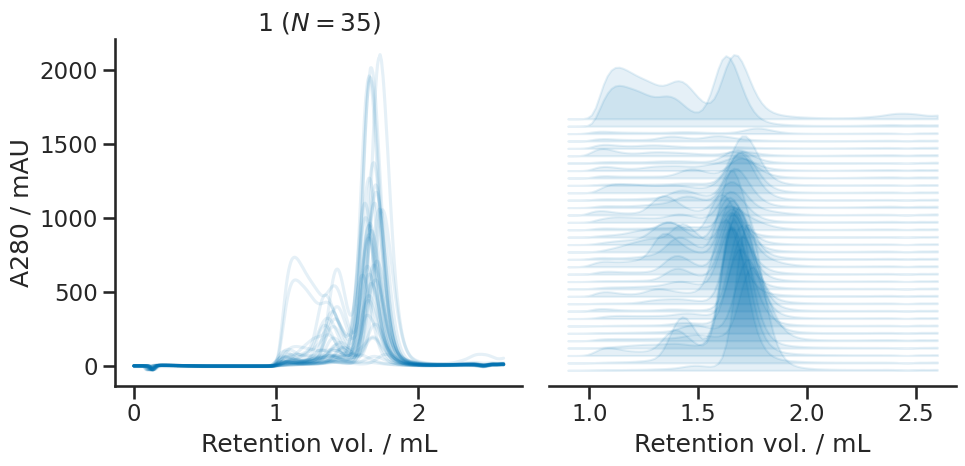

In [9]:
#plots traces grouped by plate
plot_all_traces(df)

## Calibrated results

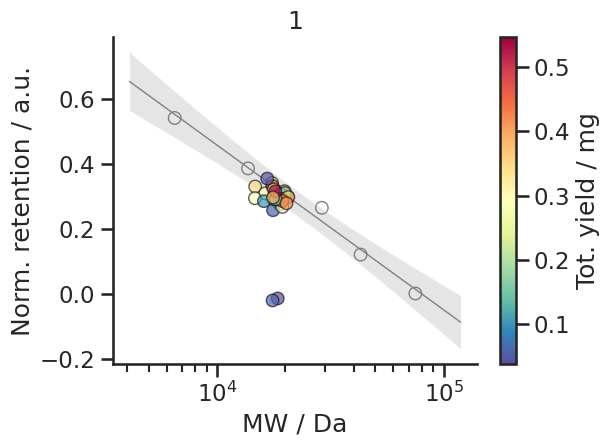

In [10]:
# Get SEC column calibration parameters and compare your runs to the expected retention time
plot_calibrated_results(df, sec_calibration, CI95)

## Per-well results

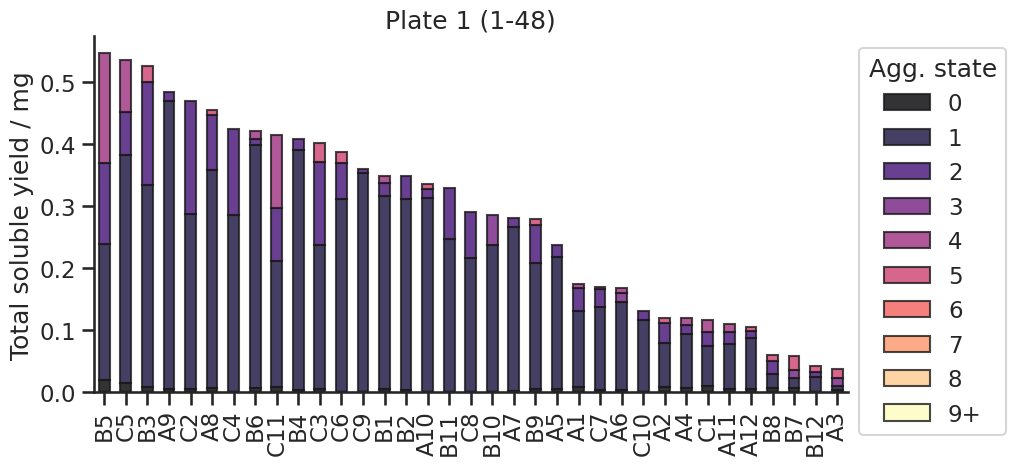

In [11]:
plot_aggregation_state_by_well(df, sec_cal)

## Pool fractions

- Choose the number of fraction to pool with `n_fractions`. Only adjacent fractions will be picked.
    - The tolerance (in mL) for what qualifies as adjacent can be specified with `adjacency`.

<!-- -->
- Choose the fraction picking logic with `how`:
    - `largest` will pick the fraction with the largest integral.
    - `nearest` will pick the fraction containing the *peak* nearest to the expected elution volume.

<!-- -->
- Use `manual_edits` if you want to overwrite the fractions that are automatically picked.


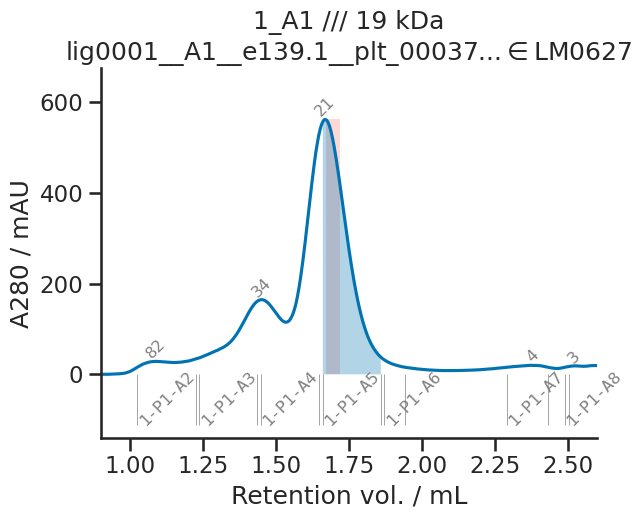

Next best fraction:
['1_A1', ['1-P1-A4']],


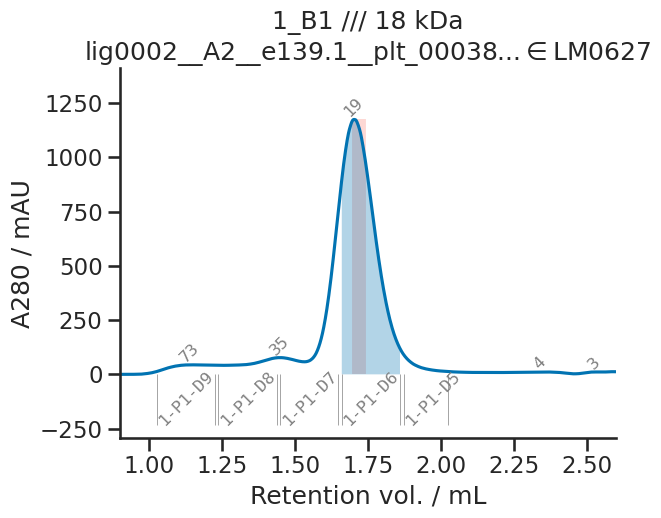

Next best fraction:
['1_B1', ['1-P1-D7']],


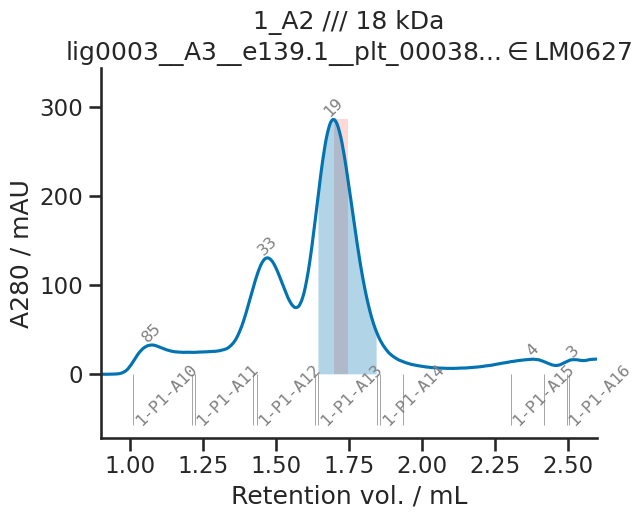

Next best fraction:
['1_A2', ['1-P1-A12']],


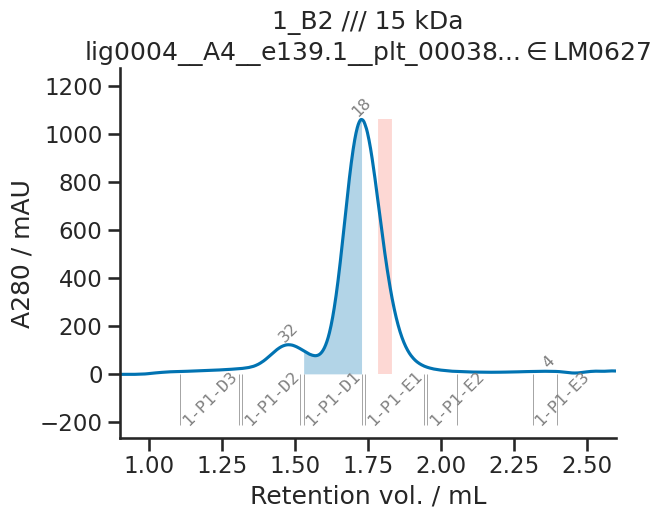

Next best fraction:
['1_B2', ['1-P1-E1']],


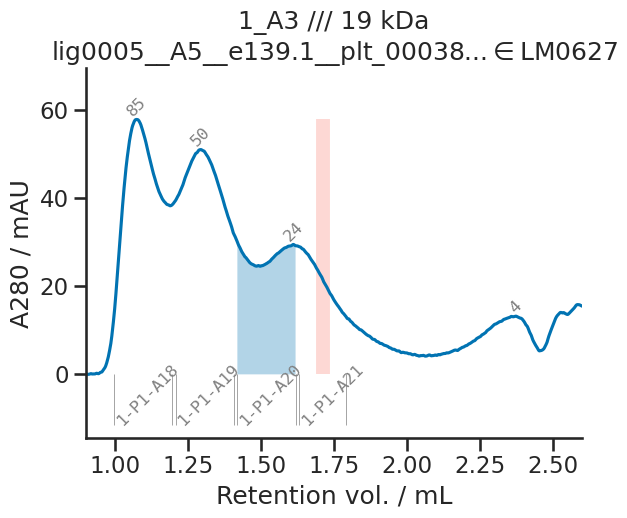

Next best fraction:
['1_A3', ['1-P1-A18']],


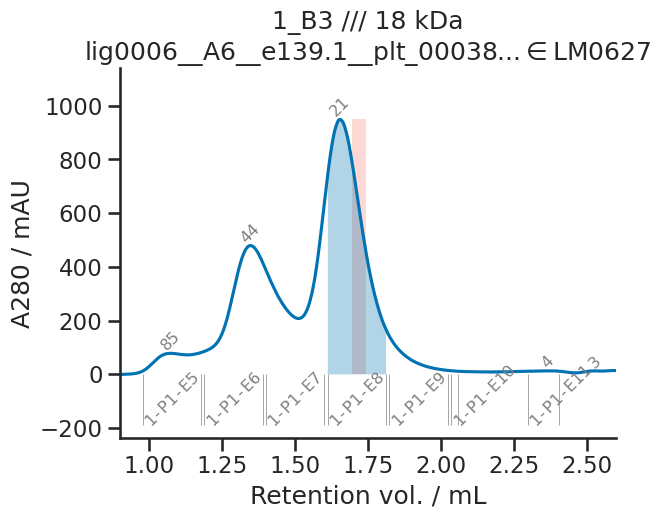

Next best fraction:
['1_B3', ['1-P1-E7']],


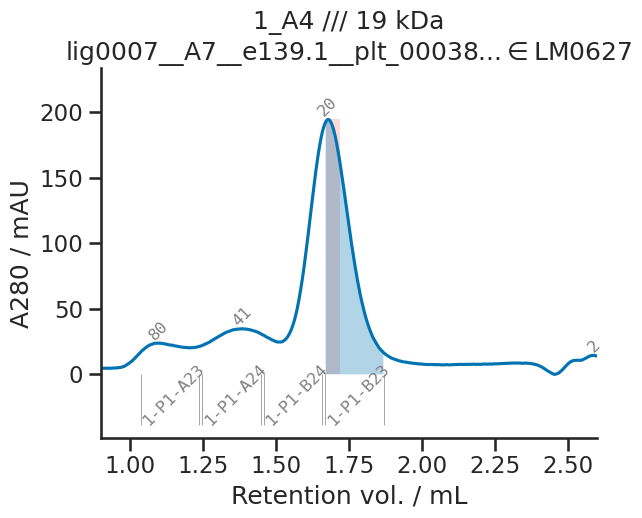

Next best fraction:
['1_A4', ['1-P1-B24']],


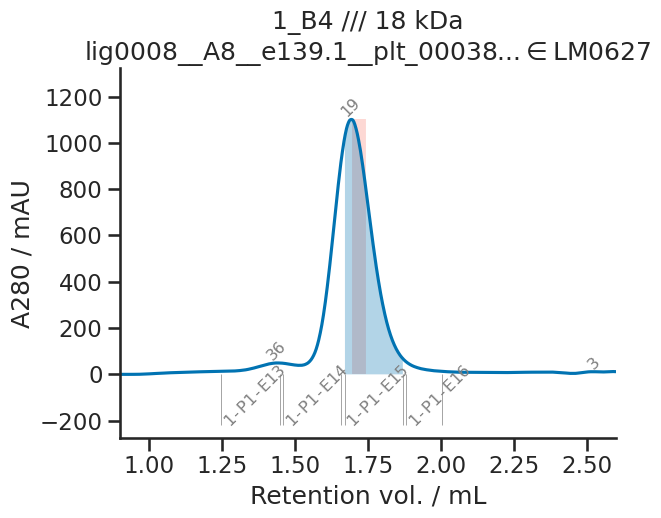

Next best fraction:
['1_B4', ['1-P1-E14']],


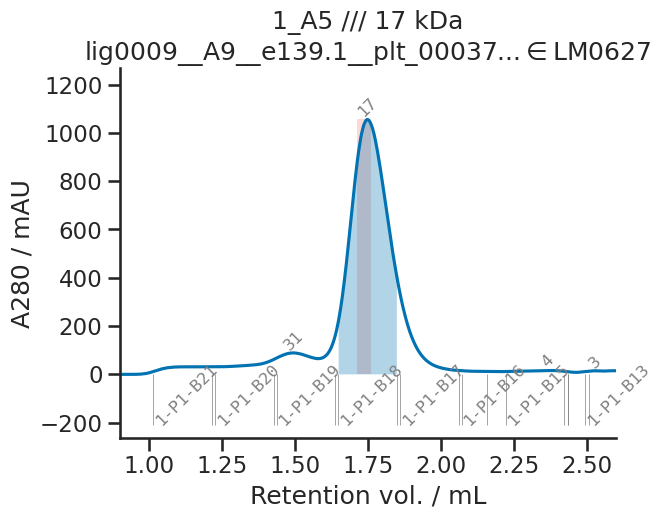

Next best fraction:
['1_A5', ['1-P1-B17']],


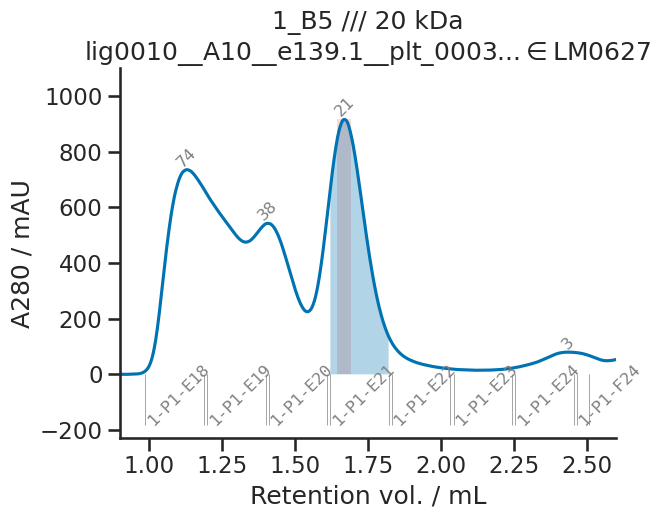

Next best fraction:
['1_B5', ['1-P1-E19']],


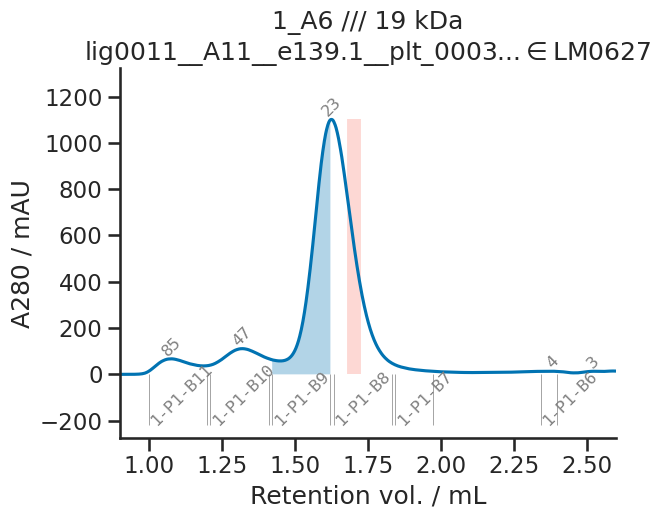

Next best fraction:
['1_A6', ['1-P1-B8']],


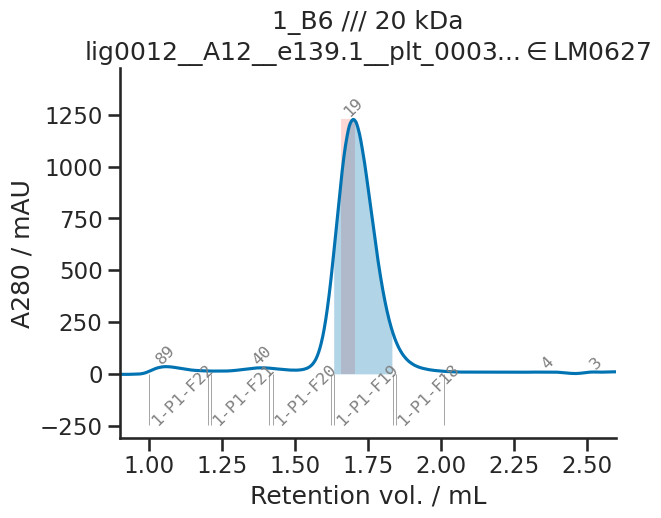

Next best fraction:
['1_B6', ['1-P1-F20']],


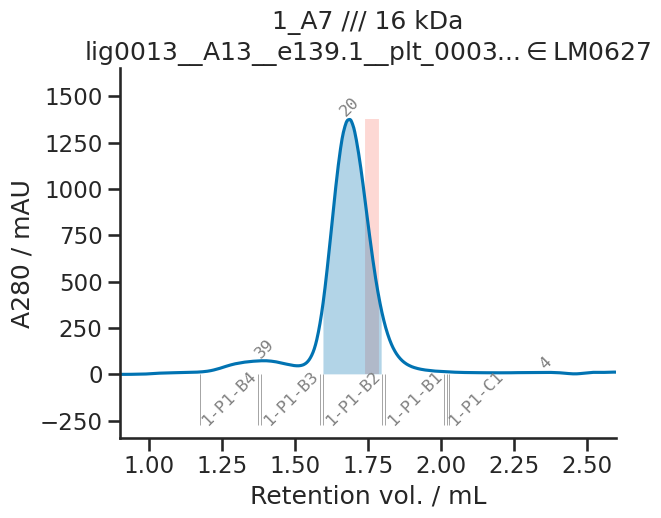

Next best fraction:
['1_A7', ['1-P1-B3']],


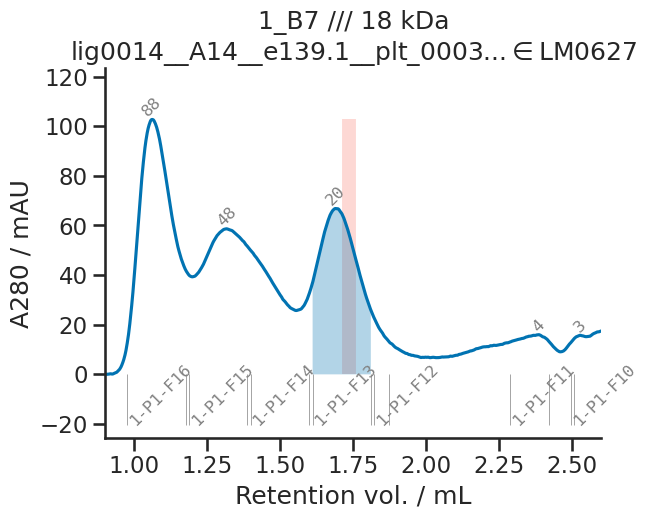

Next best fraction:
['1_B7', ['1-P1-F16']],


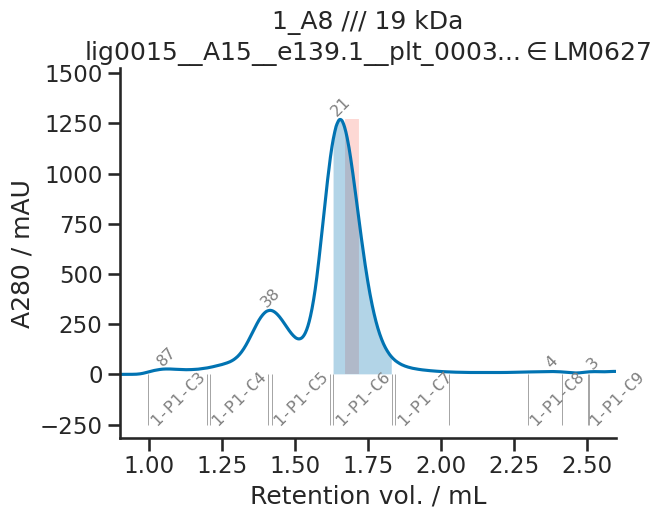

Next best fraction:
['1_A8', ['1-P1-C5']],


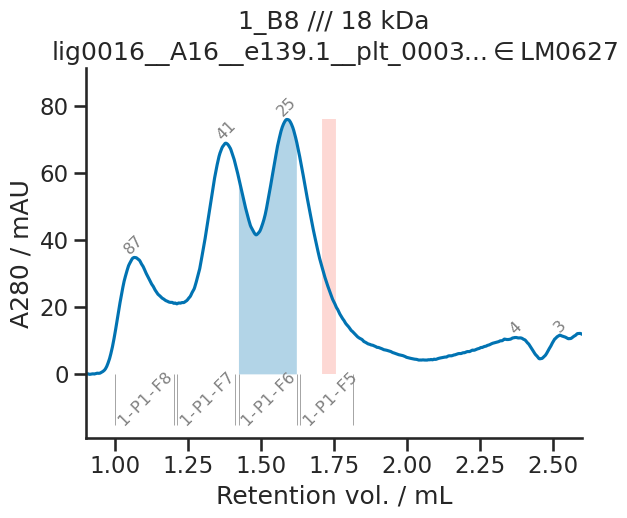

Next best fraction:
['1_B8', ['1-P1-F7']],


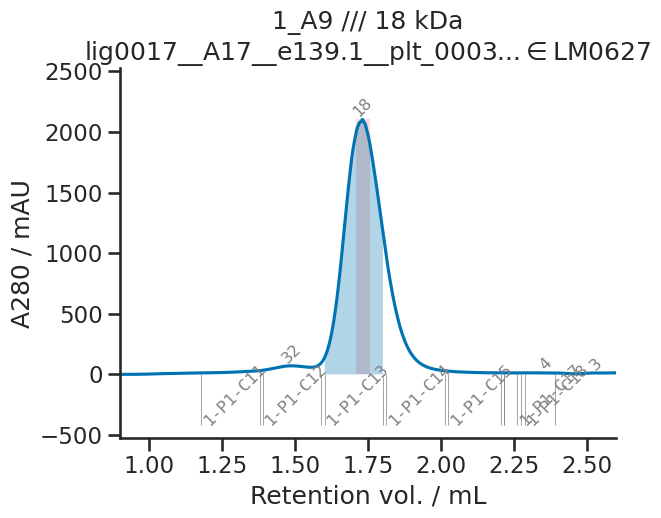

Next best fraction:
['1_A9', ['1-P1-C14']],


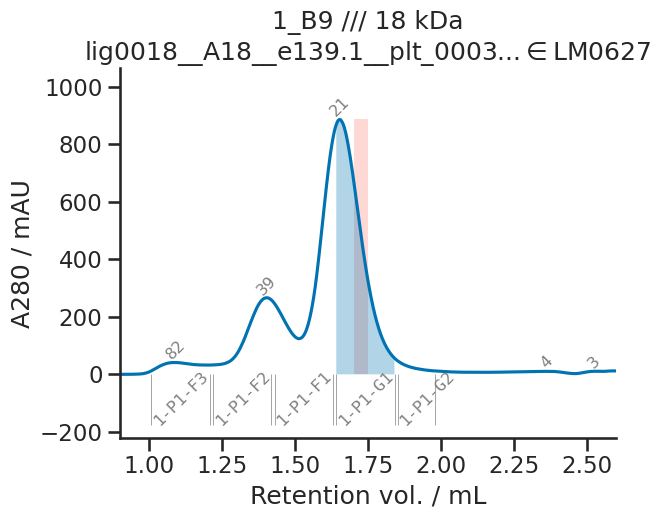

Next best fraction:
['1_B9', ['1-P1-F1']],


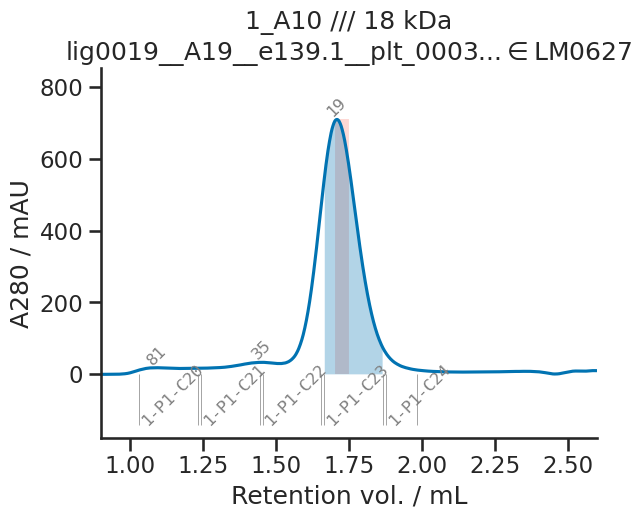

Next best fraction:
['1_A10', ['1-P1-C22']],


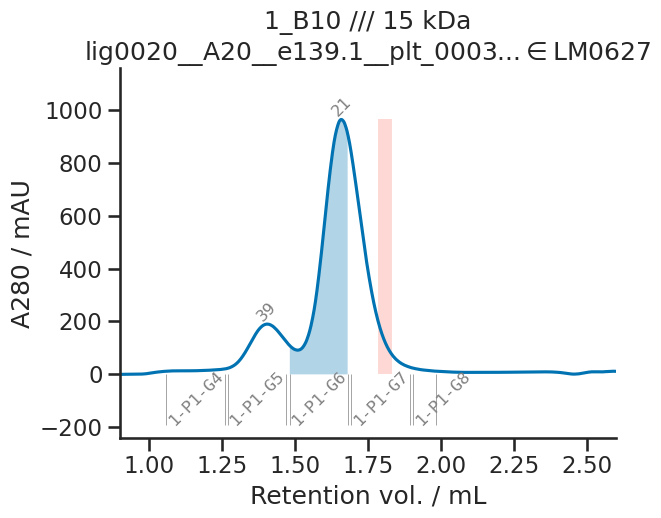

Next best fraction:
['1_B10', ['1-P1-G7']],


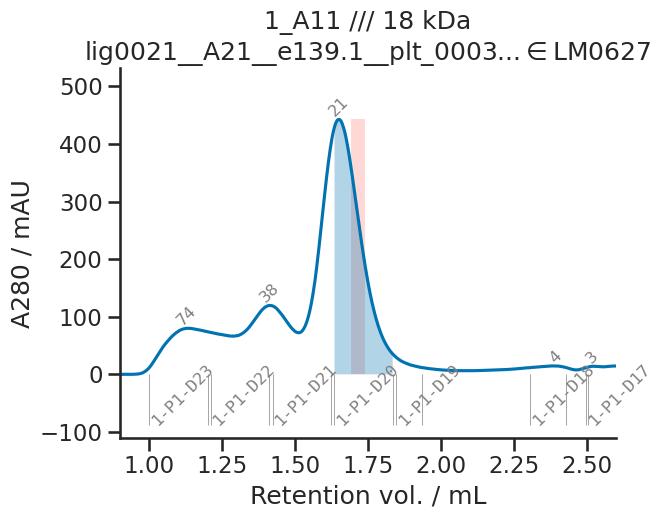

Next best fraction:
['1_A11', ['1-P1-D21']],


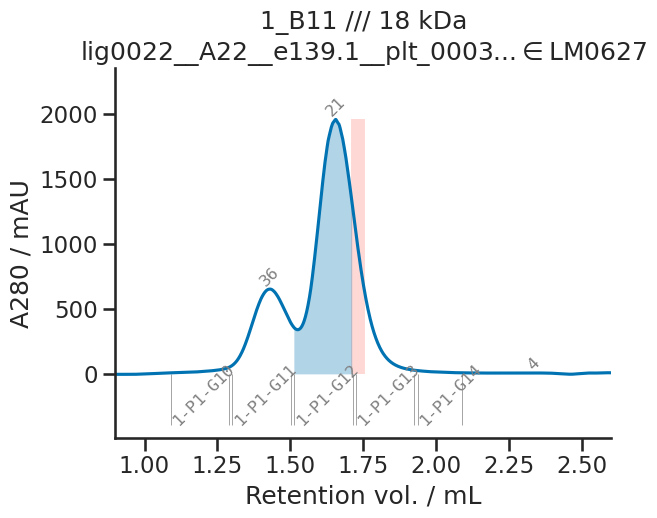

Next best fraction:
['1_B11', ['1-P1-G11']],


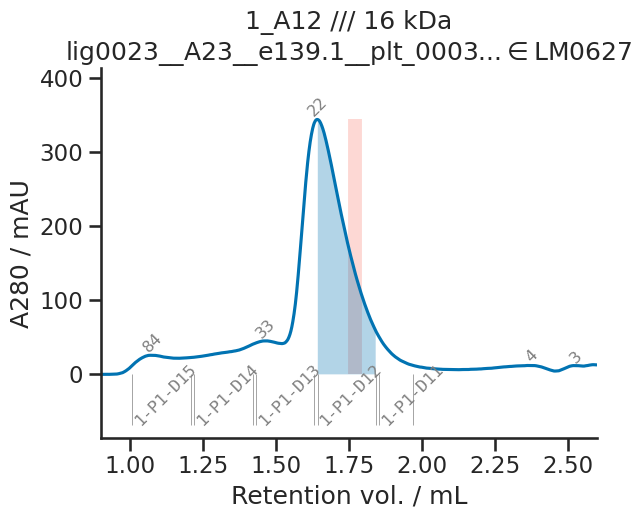

Next best fraction:
['1_A12', ['1-P1-D13']],


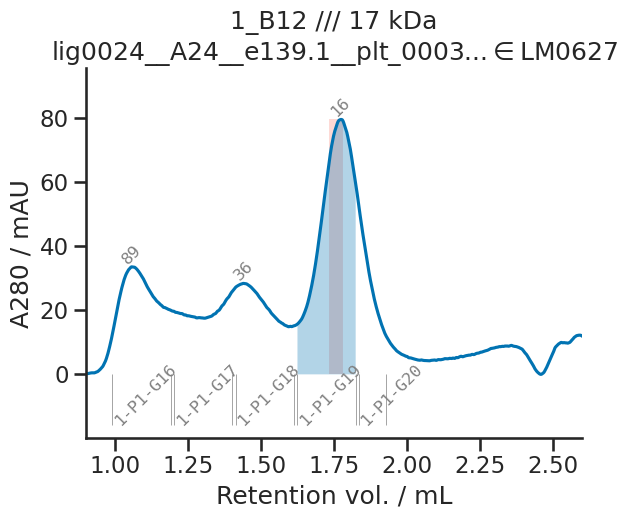

Next best fraction:
['1_B12', ['1-P1-G16']],


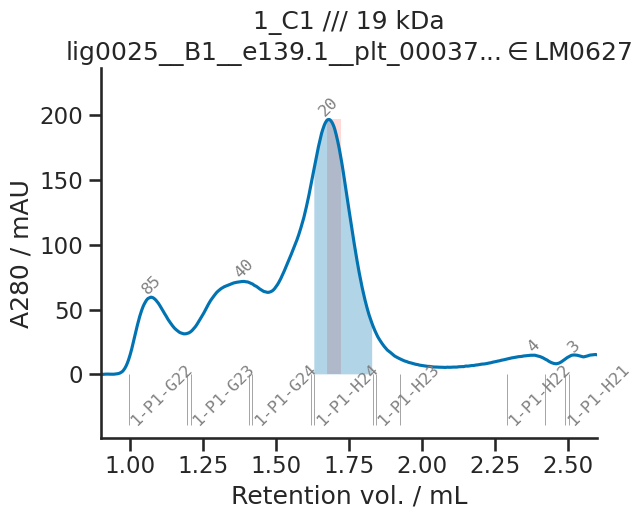

Next best fraction:
['1_C1', ['1-P1-G24']],


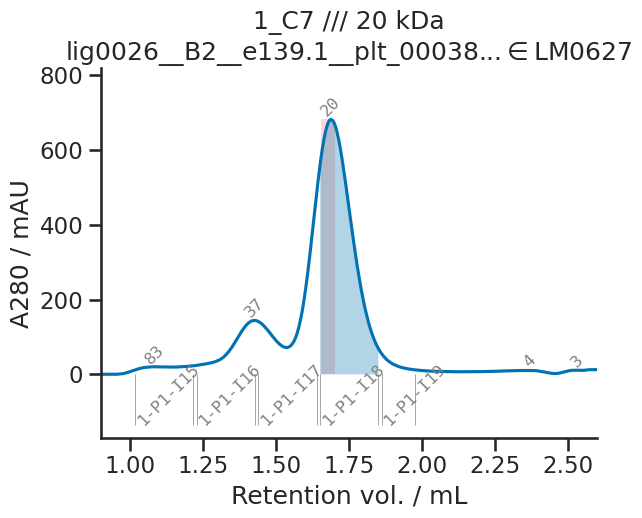

Next best fraction:
['1_C7', ['1-P1-I17']],


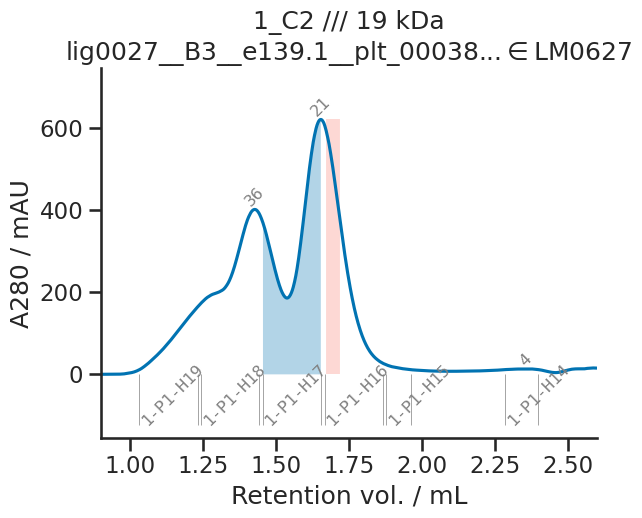

Next best fraction:
['1_C2', ['1-P1-H18']],


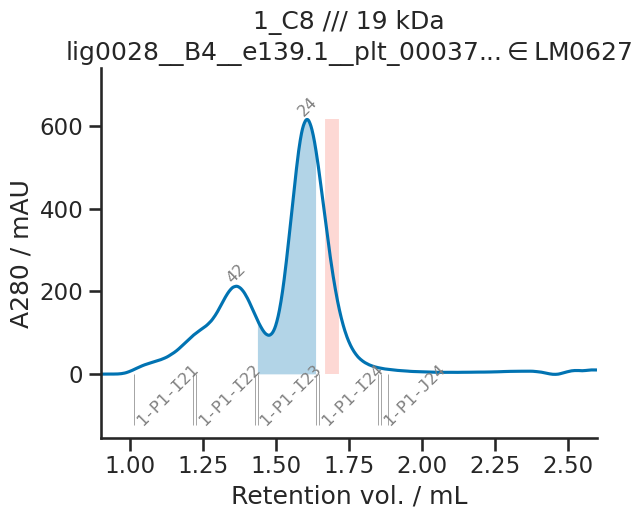

Next best fraction:
['1_C8', ['1-P1-I22']],


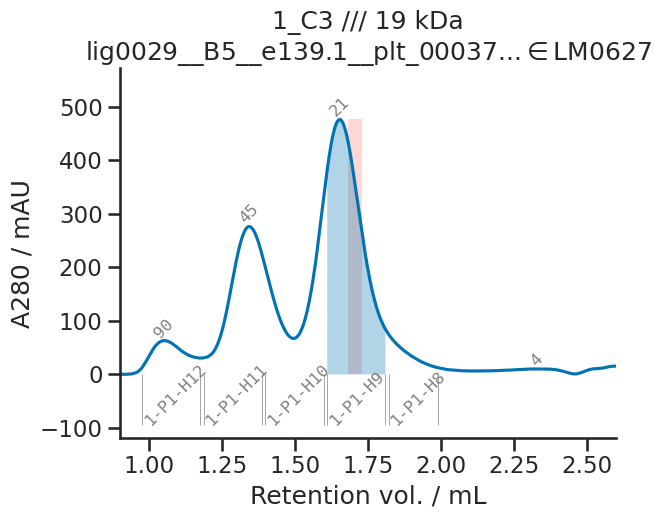

Next best fraction:
['1_C3', ['1-P1-H11']],


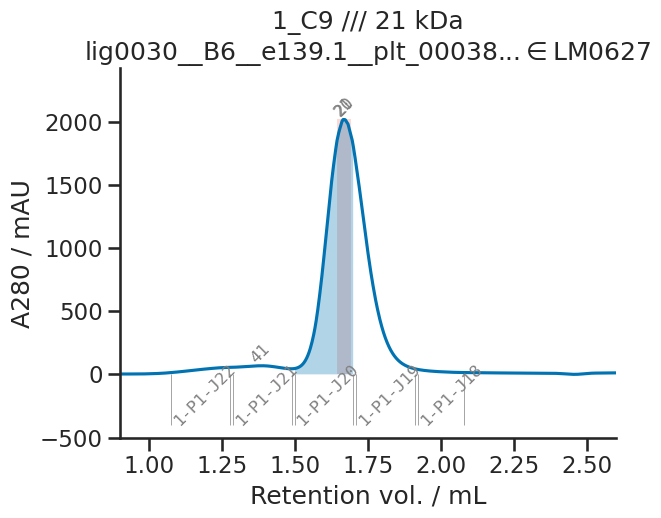

Next best fraction:
['1_C9', ['1-P1-J19']],


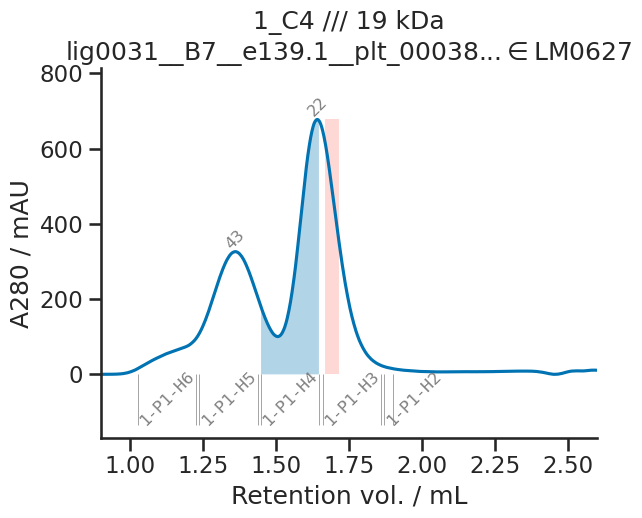

Next best fraction:
['1_C4', ['1-P1-H5']],


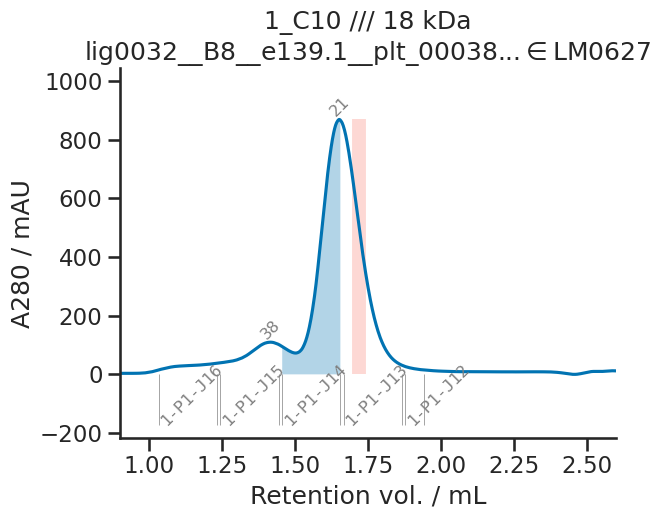

Next best fraction:
['1_C10', ['1-P1-J13']],


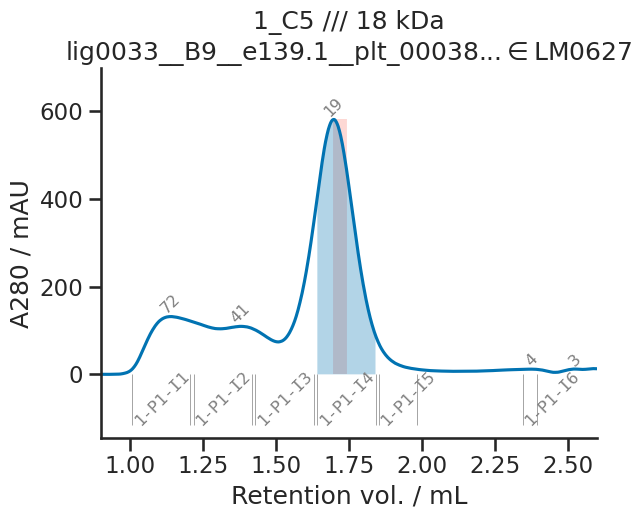

Next best fraction:
['1_C5', ['1-P1-I3']],


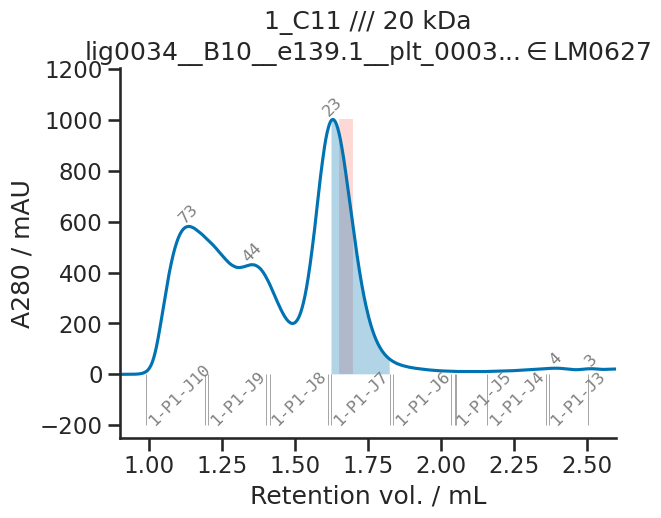

Next best fraction:
['1_C11', ['1-P1-J9']],


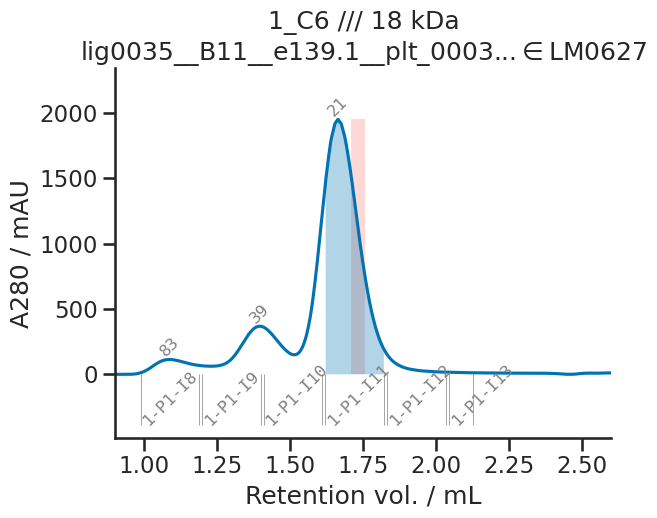

Next best fraction:
['1_C6', ['1-P1-I10']],


In [13]:
#Select nearest or largest as options for autopicking fractiions 
how = "nearest"

#If any of the fractions look bad, you can manually override the picking by writing them here.
#Examples of how to pick 1 or two fractions are in the block but commented out
#You likely will be able to just copy and paste the "next best fraction" from the output

manual_edits = np.array([
    ['well_id', ['fraction1', 'fraction2', ]],
        # ["1_C2", ["1-P1-H16"]],
        # ["1_C4", ["1-P1-H3"]],
        # ["1_C10", ["1-P1-J13", "1-P1-J14"]],
    ], dtype=object,)


### FUNCTIONALITY, DO NOT EDIT BELOW###
pooled_df = pd.DataFrame(
    columns=[
        "pooled_fractions",
        "pooled_frac_vol",
        "pooled_vol",
        "pooled_integral",
        "pooled_peak_Abs",
        "pooled_peak_vol",
    ]
)

for w, r in df.set_index("well_id").iterrows():
    select_fractions(
        w,
        r,
        pooled_df,
        manual_edits,
        sec_cal,
        wl,
        n_fractions=1,
        how,
        adjacency=0.025,
    )

## Calculate concentration and add it to the dataframe
This part also adds the dataframe to a temporary database linking eblocks and sec trace data

35


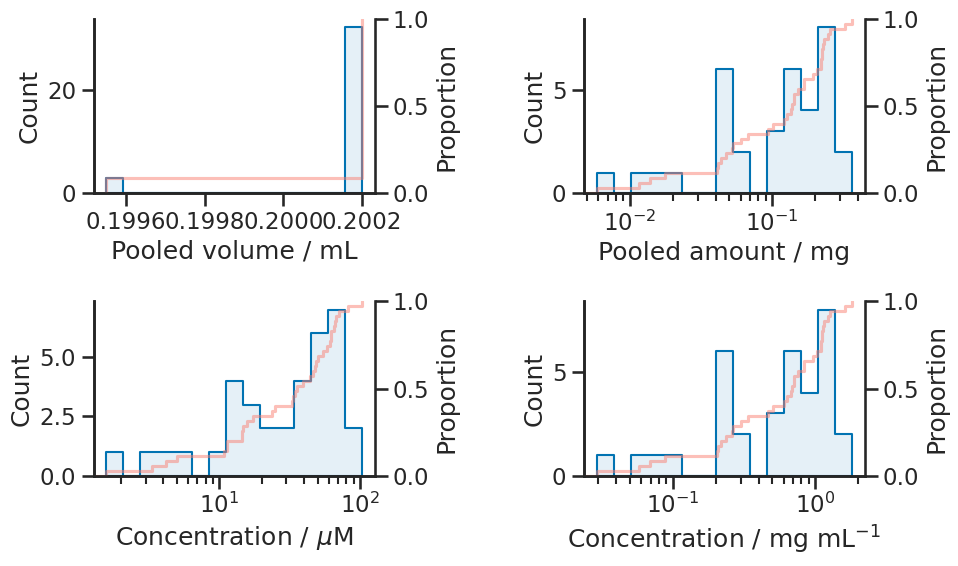

In [14]:
df = int_df.merge(pooled_df, left_on="well_id", right_index=True)
print(len(df))

df = calculate_conc_and_add_to_database(df, sec_cal, expression_name)

# Plot pooled statistics.
plot_pooled_vol_and_conc(df)

## Calculate normalization and Generate OT-2 script

In [15]:
concentration_type = "uM" #use this if you want to calculate concentration in uM
#concentration_type = "mgmL" #use this if you want to calculate in mg/mL
find_opt_concentration(df, concentration_type)

This functionality was changed in version 8. Make sure you've grabbed the most recent copy of the template from /software/lab/cowboy/
Choosing 1.5199110829529348 uM will give 100.0% correct wells. This is the highest percentage
Choosing 4.64 uM will give 91.42857142857143% correct wells.
Choosing 14.17 uM will give 80.0% correct wells.


88.6% of wells will have the desired concentration.


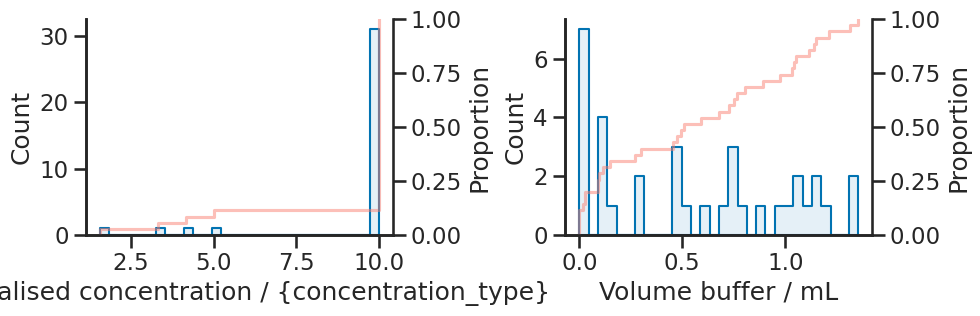

In [76]:
normalize = False #if you don't actually want to normalize your samples change it here
desired_conc = 10  # uM unless you changed it
max_volume = 1.5 # mL any more than this can make it hard to pipette your samples

calculate_dilutions(df, desired_conc, concentration_type, max_volume)

# Plot normalization statistics.
plot_conc_and_vol_after_norm(df)
gen_ot2_script(
    df.dropna(),
    sec_instrument,
    normalize,
    #path="/home/ach94/projects/p05_peptide_ligase/e151_ligase_cowboy/cowboy/",
    separate_non_normed=False,
    template="/net/software/lab/cowboy/SEC_pool_and_norm_v3.py",
)

## Legacy Plots

In [ ]:
#Plots soluble yield in mg overall and by plate (category)
plot_total_soluble_yield(df)

In [ ]:
plot_peak_distribution(df)

In [ ]:
#Gray bar shows the expected retention time
#dots are individual runs, colored by their total yield
plot_peak_retention_over_norm_retention(df)

In [ ]:
plot_aggregation_state_by_plate(df)